In [1]:
"""
this script will create the simulation of having two lenses and vary the distance between them
and plot the optical power vs distance for the combined error
"""

import win32com.client
import os
import numpy as np
import time
from params import Params
import matplotlib.pyplot as plt
import codev_helper as cvh
import os


In [2]:

# ==============================================================================
# Helper Functions
# ==============================================================================

params = Params()
    

def tilt2power(tilt):
    delta = -tilt*params.f0
    optical_power = delta*12*(params.eta - params.eta_air)/params.C0
    return optical_power

def rotate_lohmann_lens(cv_session, surface, theta = 0, c0 = 1/0.00013312, debug=False):

    # compute coefficients
    x3 = 1/c0 * (np.sin(theta)**3 + np.cos(theta)**3)
    x2y = 3/c0 * (np.sin(theta)**2 * np.cos(theta) - np.cos(theta)**2 * np.sin(theta))
    xy2 = 3/c0 * (np.sin(theta)**2 * np.cos(theta) + np.sin(theta) * np.cos(theta)**2)
    y3 = 1/c0 * (np.cos(theta)**3 - np.sin(theta)**3)

    lohmann_surf = surface
    x3_set_command = f"SCO {lohmann_surf} C7 {str(x3)}"
    x2y_set_command = f"SCO {lohmann_surf} C8 {str(x2y)}"
    xy2_set_command = f"SCO {lohmann_surf} C9 {str(xy2)}"
    y3_set_command = f"SCO {lohmann_surf} C10 {str(y3)}"

    # set coefficients
    output = cv_session.Command(x3_set_command)
    if debug:
        print(f"Setting {x3_set_command}, output: {output}")
    output = cv_session.Command(x2y_set_command)
    if debug:
        print(f"Setting {x2y_set_command}, output: {output}")
    output = cv_session.Command(xy2_set_command)
    if debug:
        print(f"Setting {xy2_set_command}, output: {output}")
    output = cv_session.Command(y3_set_command)
    if debug:
        print(f"Setting {y3_set_command}, output: {output}")

def rotate_SLM_y(cv_session, dummy_surface, theta = 0, debug=False):

    a_coeff = "C2"
    x2_coeff = "C4"
    x3_coeff = "C7"

    # calculate the constants from the angle
    sin_th = np.sin(theta)
    cos_th = np.cos(theta)

    # set x2 = a * sin(th) + cos(th)
    command_x2 = f"PIK SCO {x2_coeff} {dummy_surface} SCO {a_coeff} {dummy_surface} {str(sin_th)} {str(cos_th)}"
    output = cv_session.Command(command_x2)
    if debug:
        print(f"Setting {command_x2}, output: {output}")

    # set x3 = a * cos(th) - sin(th)
    command_x3 = f"PIK SCO {x3_coeff} {dummy_surface} SCO {a_coeff} {dummy_surface} {str(cos_th)} {str(-sin_th)}"
    output = cv_session.Command(command_x3)
    if debug:
        print(f"Setting {command_x3}, output: {output}")

def rotate_SLM_x(cv_session, dummy_surface, theta = 0, debug=False):

    a_coeff = "C2"
    x2_coeff = "C4"
    x3_coeff = "C7"

    # calculate the constants from the angle
    sin_th = np.sin(theta)
    cos_th = np.cos(theta)

    # set x2 = a * sin(th) + cos(th)
    command_x2 = f"PIK SCO {x2_coeff} {dummy_surface} SCO {a_coeff} {dummy_surface} {str(-sin_th)} {str(cos_th)}"
    output = cv_session.Command(command_x2)
    if debug:
        print(f"Setting {command_x2}, output: {output}")

    # set x3 = a * cos(th) - sin(th)
    command_x3 = f"PIK SCO {x3_coeff} {dummy_surface} SCO {a_coeff} {dummy_surface} {str(cos_th)} 0"
    output = cv_session.Command(command_x3)
    if debug:
        print(f"Setting {command_x3}, output: {output}")


    

def get_power_vs_distance_with_epsilon(cv_session, surface1, surface2, surface3, st1, st2, st3, theta, distances):
    
    cvHelper.set_surf_thickness(surface1, st1)  
    cvHelper.set_surf_thickness(surface2, st2)  
    cvHelper.set_surf_thickness(surface3, st3)

    # roate the lohmann lenses
    lohmann_surf = "S9"
    rotate_lohmann_lens(cv_session, lohmann_surf, theta)
    
    powers = []
    for d in distances:
        
        # set the object distance
        #print(f"Setting object distance to {d*1000} mm...")
        cv_session.Command(f"THI S0 {d*1000}")

        # apply vignetting
        cvHelper.apply_vignetting()

        # perform automatic optimization
        optimization_command = "AUT; P YES; ERR CDV; MNC 5; DRA S1..30  NO; EFP ALL Y; EFT TA; GLA SO..I  NFK5 NSK16 NLAF2 SF4; GO"
        #print(f"  Performing optimization: {optimization_command}")
        cv_session.Command(optimization_command)

        # get the value of the tilt
        tilt = cvHelper.query_xypolynomial_coeff("S13", "C2")
        power = tilt2power(tilt)

        # store
        powers.append(power)

        # print percentage completed 
        print(power)

    return powers


def get_power_vs_distance_with_SLM_tilt(cv_session, surface1, surface2, surface3, st1, st2, st3, theta_lohmann, theta_SLM, distances, axis='y'):
    
    cvHelper.set_surf_thickness(surface1, st1)  
    cvHelper.set_surf_thickness(surface2, st2)  
    cvHelper.set_surf_thickness(surface3, st3)

    # roate the lohmann lenses
    lohmann_surf = "S9"
    rotate_lohmann_lens(cv_session, lohmann_surf, theta_lohmann)
    # rotate the SLM
    dummy_surface = "S14"
    rotate_SLM_y(cv_session, dummy_surface, theta_SLM)
    
    powers = []
    for d in distances:
        
        # set the object distance
        #print(f"Setting object distance to {d*1000} mm...")
        cv_session.Command(f"THI S0 {d*1000}")

        # apply vignetting
        cvHelper.apply_vignetting()

        # perform automatic optimization
        if axis == 'y':
            optimization_command = get_optimization_with_SLM_tilt_y_command()
        elif axis == 'x':
            optimization_command = get_optimization_with_SLM_tilt_x_command()
        else:
            raise ValueError("Axis must be 'x' or 'y'")
        
        print(f"  Performing optimization: {optimization_command}")
        output = cv_session.Command(optimization_command)
        print(output)

        # get the value of the tilt
        tilt = cvHelper.query_xypolynomial_coeff("S14", "C2")
        power = tilt2power(tilt)

        # store
        powers.append(power)

        # print percentage completed 
        print(power)

    return powers

def get_optimization_with_SLM_tilt_y_command():
    return "AUT; @x_coeff == 1/(SCO S14 C4) * (SCO S14 C7) - (SCO S13 C2); @y_coeff == (SCO S14 C2) / (SCO S14 C4) - (SCO S13 C3); @x_coeff = 0; \
            @y_coeff = 0; STP YES; ERR CDV; MNC 5; DRA S1..30  NO; EFP ALL Y; EFT TA; GLA SO..I  NFK5 NSK16 NLAF2 SF4; GO "

def get_optimization_with_SLM_tilt_x_command():
    return "AUT; @x_coeff == (SCO S14 C2)/(SCO S14 C4) * (SCO S14 C7) - (SCO S13 C2); @y_coeff == (SCO S14 C7) / (SCO S14 C4) - (SCO S13 C3); @x_coeff = 0; \
            @y_coeff = 0; STP YES; ERR CDV; MNC 5; DRA S1..30  NO; EFP ALL Y; EFT TA; GLA SO..I  NFK5 NSK16 NLAF2 SF4; GO "

Successfully created CODE V session object.
CODE V background process started. Version: 2022.03.SR1;Build (35834663)
Opening lens: c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera...
Lens opened. CODE V response: Warning: Index measured at 20.00 degrees with lens system at 22.00
               degrees for glass SILICA_SPECIAL
    File c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera.len has been restored
    Lens title: "AC254-100-A AC254-100-A POSITIVE VISIBLE ACHROMATS: Infinite 100"
    Error function:  0.1900246E+04
Command End:

Initial thicknesses - S3: 70.16935013025 mm, S22: 97.068 mm, S29: 43.22018758686 mm
    SCO S13 C2 = -0.015707513269
Command End:

1.1559826458511664
    SCO S13 C2 = -0.012388289309
Command End:

0.9117068505840737
    SCO S13 C2 = -0.010147244117
Command End:

0.7467788122526999
    SCO S13 C2 = -0.008527836833
Command End:

0.6275997490356391
    SCO S13 C2 = -0.002166793052
Command End:

0.15946350783648566
   

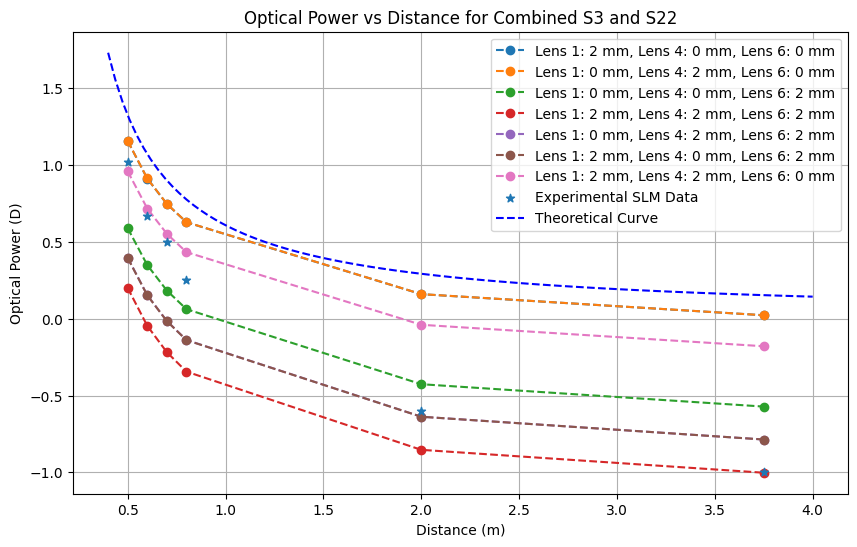

In [5]:

if __name__ == '__main__':
    # --- Configuration for CodeV session ---
    WORKING_DIR = os.getcwd() + "\\"
    LENS_FILE = WORKING_DIR + "system_with_camera" 
    RESULTS_DIR = WORKING_DIR + "sensitivity_analysis\\"

    # --- initialise variables ---
    distances = [0.5, 0.6, 0.7, 0.8, 2, 3.75]
    epsilon = 2

    # surfaces for each epsilon
    e1_surface = "S3"           # Lens 1 to Lens 2
    e2_surface = "S7"           # Lens 2 to Lohmann lens
    e3_surface = "S9"           # Lohmann to lens 3
    e4_surface = "S12"          # Lens 3 to SLM
    e5_surface = "S13"          # Lens 3 to SLM e5 must be  e5 = -e4
    e6_surface = "S22"          # Lens 4 to lens 5
    e7_surface = "S26"          # Lens 5 to lens 6
    e8_surface = "S29"          # Lens 6 to camera's sensor

    # --- 2. Initialize and Start CODE V Session ---
    cv_session = None

    try: 
        # create the COM object to interact with CODE V
        cv_session = win32com.client.Dispatch("CodeV.Application")
        print("Successfully created CODE V session object.")

        # set the working directory and start the background process
        cv_session.StartingDirectory = WORKING_DIR
        cv_session.StartCodeV()
        print(f"CODE V background process started. Version: {cv_session.CodeVVersion}")

        # open the specified lens file
        print(f"Opening lens: {LENS_FILE}...")
        output = cv_session.Command(f"RES {LENS_FILE}")
        print(f"Lens opened. CODE V response: {output}")

        # Ensure the results directory exists
        if not os.path.exists(RESULTS_DIR):
            os.makedirs(RESULTS_DIR)
            print(f"Created results directory: {RESULTS_DIR}")

        # Initialize CodeVHelper
        cvHelper = cvh.CodeVHelper(cv_session)

        # get initial thickness of the surfaces
        s1_t = cvHelper.query_surf_thickness(e1_surface)
        s2_t = cvHelper.query_surf_thickness(e2_surface)
        s3_t = cvHelper.query_surf_thickness(e3_surface)
        s4_t = cvHelper.query_surf_thickness(e4_surface)
        s5_t = cvHelper.query_surf_thickness(e5_surface)
        s6_t = cvHelper.query_surf_thickness(e6_surface)
        s7_t = cvHelper.query_surf_thickness(e7_surface)
        s8_t = cvHelper.query_surf_thickness(e8_surface)

        surfaces_thickness = [s1_t, s6_t, s8_t]

        print(f"Initial thicknesses - {e1_surface}: {s1_t} mm, {e6_surface}: {s6_t} mm, {e8_surface}: {s8_t} mm")
        
        # reset thicknesses
        cvHelper.set_surf_thickness(e1_surface, s1_t)
        cvHelper.set_surf_thickness(e6_surface, s6_t)
        cvHelper.set_surf_thickness(e8_surface, s8_t)
        

        # --- Main Processing Loop ---

        #  experimental result
        p_SLM_m = [1.02, 0.67, 0.5, 0.25, -0.6, -1]

        # plot the theoretical curve
        d = np.linspace(0.4, 4, 100)  # distance in meters
        P = 9 / (16 * (d - 0.075))


        plt.figure(figsize=(10, 6))
        
        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 2, s6_t + 0, s8_t + 0, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {2} mm, Lens 4: {0} mm, Lens 6: {0} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 0, s6_t + 2, s8_t + 0, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {0} mm, Lens 4: {2} mm, Lens 6: {0} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 0, s6_t + 0, s8_t + 2, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {0} mm, Lens 4: {0} mm, Lens 6: {2} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 2, s6_t + 2, s8_t + 2, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {2} mm, Lens 4: {2} mm, Lens 6: {2} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 0, s6_t + 2, s8_t + 2, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {0} mm, Lens 4: {2} mm, Lens 6: {2} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 2, s6_t + 0, s8_t + 2, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {2} mm, Lens 4: {0} mm, Lens 6: {2} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 2, s6_t + 2, s8_t + 0, 0, distances)
        plt.plot(distances, powers, 'o--', label=f"Lens 1: {2} mm, Lens 4: {2} mm, Lens 6: {0} mm")


        
        plt.scatter(distances, p_SLM_m, marker='*', label="Experimental SLM Data", zorder=1000)
        plt.plot(d, P, 'b--', label="Theoretical Curve")
        plt.xlabel("Distance (m)")
        plt.ylabel("Optical Power (D)")
        plt.title("Optical Power vs Distance for Combined S3 and S22")
        plt.grid()
        plt.legend()

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # --- Crlan Up and Close session ---
        if cv_session:
            cv_session.StopCodeV()
            print("\nCODE V session stopped.")
            cv_session = None


Successfully created CODE V session object.
CODE V background process started. Version: 2022.03.SR1;Build (35834663)
Opening lens: c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera...
Lens opened. CODE V response: Warning: Index measured at 20.00 degrees with lens system at 22.00
               degrees for glass SILICA_SPECIAL
    File c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera.len has been restored
    Lens title: "AC254-100-A AC254-100-A POSITIVE VISIBLE ACHROMATS: Infinite 100"
    Error function:  0.1900246E+04
Command End:

Initial thicknesses - S3: 70.16935013025 mm, S22: 97.068 mm, S29: 43.22018758686 mm
0.39476822454682126
0.15217498111383393
-0.01590146214061502
-0.1394944894965959
-0.6382570051134235
-0.7864366153741582
0.9757429214129236
0.7358417950622365
0.5727466498410065
0.4541825174296487
-0.0168974511780016
-0.1563673364612189

CODE V session stopped.


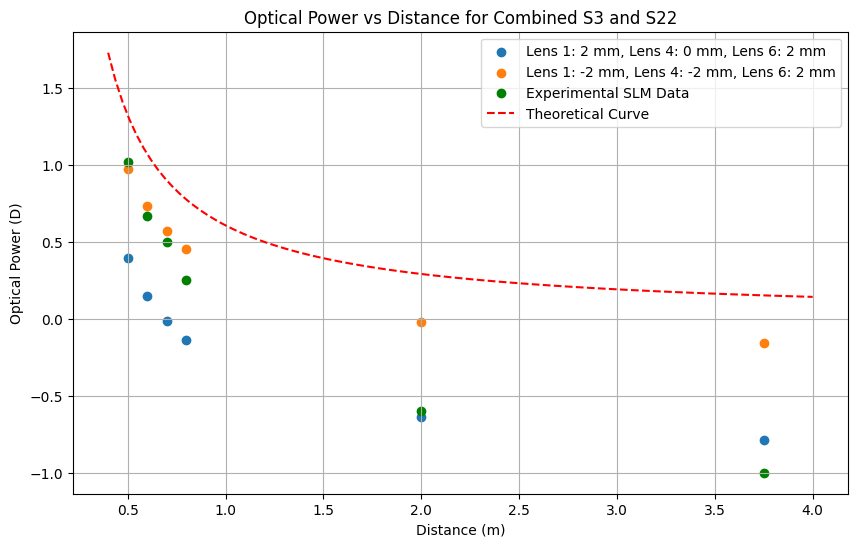

In [11]:

if __name__ == '__main__':
    # --- Configuration for CodeV session ---
    WORKING_DIR = os.getcwd() + "\\"
    LENS_FILE = WORKING_DIR + "system_with_camera" 
    RESULTS_DIR = WORKING_DIR + "sensitivity_analysis\\"

    # --- initialise variables ---
    distances = [0.5, 0.6, 0.7, 0.8, 2, 3.75]
    epsilon = 2

    # surfaces for each epsilon
    e1_surface = "S3"           # Lens 1 to Lens 2
    e2_surface = "S7"           # Lens 2 to Lohmann lens
    e3_surface = "S9"           # Lohmann to lens 3
    e4_surface = "S12"          # Lens 3 to SLM
    e5_surface = "S13"          # Lens 3 to SLM e5 must be  e5 = -e4
    e6_surface = "S22"          # Lens 4 to lens 5
    e7_surface = "S26"          # Lens 5 to lens 6
    e8_surface = "S29"          # Lens 6 to camera's sensor

    # --- 2. Initialize and Start CODE V Session ---
    cv_session = None

    try: 
        # create the COM object to interact with CODE V
        cv_session = win32com.client.Dispatch("CodeV.Application")
        print("Successfully created CODE V session object.")

        # set the working directory and start the background process
        cv_session.StartingDirectory = WORKING_DIR
        cv_session.StartCodeV()
        print(f"CODE V background process started. Version: {cv_session.CodeVVersion}")

        # open the specified lens file
        print(f"Opening lens: {LENS_FILE}...")
        output = cv_session.Command(f"RES {LENS_FILE}")
        print(f"Lens opened. CODE V response: {output}")

        # Ensure the results directory exists
        if not os.path.exists(RESULTS_DIR):
            os.makedirs(RESULTS_DIR)
            print(f"Created results directory: {RESULTS_DIR}")

        # Initialize CodeVHelper
        cvHelper = cvh.CodeVHelper(cv_session)

        # get initial thickness of the surfaces
        s1_t = cvHelper.query_surf_thickness(e1_surface)
        s2_t = cvHelper.query_surf_thickness(e2_surface)
        s3_t = cvHelper.query_surf_thickness(e3_surface)
        s4_t = cvHelper.query_surf_thickness(e4_surface)
        s5_t = cvHelper.query_surf_thickness(e5_surface)
        s6_t = cvHelper.query_surf_thickness(e6_surface)
        s7_t = cvHelper.query_surf_thickness(e7_surface)
        s8_t = cvHelper.query_surf_thickness(e8_surface)

        surfaces_thickness = [s1_t, s6_t, s8_t]

        print(f"Initial thicknesses - {e1_surface}: {s1_t} mm, {e6_surface}: {s6_t} mm, {e8_surface}: {s8_t} mm")
        
        # reset thicknesses
        cvHelper.set_surf_thickness(e1_surface, s1_t)
        cvHelper.set_surf_thickness(e6_surface, s6_t)
        cvHelper.set_surf_thickness(e8_surface, s8_t)
        

        # --- Main Processing Loop ---

        #  experimental result
        p_SLM_m = [1.02, 0.67, 0.5, 0.25, -0.6, -1]

        # plot the theoretical curve
        d = np.linspace(0.4, 4, 100)  # distance in meters
        P = 9 / (16 * (d - 0.075))


        plt.figure(figsize=(10, 6))
        

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 2, s6_t + 0, s8_t + 2, distances)
        plt.scatter(distances, powers, label=f"Lens 1: {2} mm, Lens 4: {0} mm, Lens 6: {2} mm")

        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + -2, s6_t + -2, s8_t + 2, distances)
        plt.scatter(distances, powers, label=f"Lens 1: {-2} mm, Lens 4: {-2} mm, Lens 6: {2} mm")


        
        plt.scatter(distances, p_SLM_m, marker='o', color='g', label="Experimental SLM Data")
        plt.plot(d, P, 'r--', label="Theoretical Curve")
        plt.xlabel("Distance (m)")
        plt.ylabel("Optical Power (D)")
        plt.title("Optical Power vs Distance for Combined S3 and S22")
        plt.grid()
        plt.legend()

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # --- Crlan Up and Close session ---
        if cv_session:
            cv_session.StopCodeV()
            print("\nCODE V session stopped.")
            cv_session = None


Errors between theoretical and simulated powers: [0.7305600145961182, 0.7203090320840895, 0.7157853537539297, 0.7171615593715814, 0.7159922487658755, 0.7218007152993038]
Errors between theoretical and experimental powers: [0.30000000000000004, 0.4, 0.4, 0.53, 0.8899999999999999, 1.15]


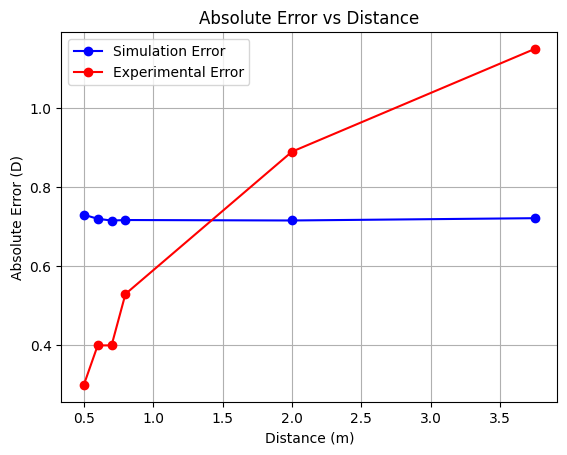

In [10]:
# calculate the error
t_power = [1.32, 1.07, 0.9, 0.78, 0.29, 0.15]
errors_sim = [abs(t - p) for t, p in zip(t_power, powers)]
errors_exp = [abs(t - p) for t, p in zip(t_power, p_SLM_m)]
print("Errors between theoretical and simulated powers:", errors_sim)
print("Errors between theoretical and experimental powers:", errors_exp)

plt.figure()
plt.plot(distances, errors_sim, 'b-o', label="Simulation Error")
plt.plot(distances, errors_exp, 'r-o', label="Experimental Error")
plt.xlabel("Distance (m)")
plt.ylabel("Absolute Error (D)")
plt.title("Absolute Error vs Distance")
plt.grid()
plt.legend()


# Rotating the Lohman lens


Successfully created CODE V session object.
CODE V background process started. Version: 2022.03.SR1;Build (35834663)
Opening lens: c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera...
Lens opened. CODE V response: Warning: Index measured at 20.00 degrees with lens system at 22.00
               degrees for glass SILICA_SPECIAL
    File c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera.len has been restored
    Lens title: "AC254-100-A AC254-100-A POSITIVE VISIBLE ACHROMATS: Infinite 100"
    Error function:  0.1900246E+04
Command End:

Initial thicknesses - S3: 70.16935013025 mm, S22: 97.068 mm, S29: 43.22018758686 mm
1.206757994850783
0.9167051926406392
0.7176289347500003
0.5725944026211025
-0.010568822254736427
-0.18714736729606554
1.1554852778844733
0.8754633351169332
0.6843575166341536
0.5452504945820129
-0.012433218744744415
-0.18031024115256877
1.1122299605220611
0.8413698188254475
0.6569803695316297
0.522824967638195
-0.013766505592699685


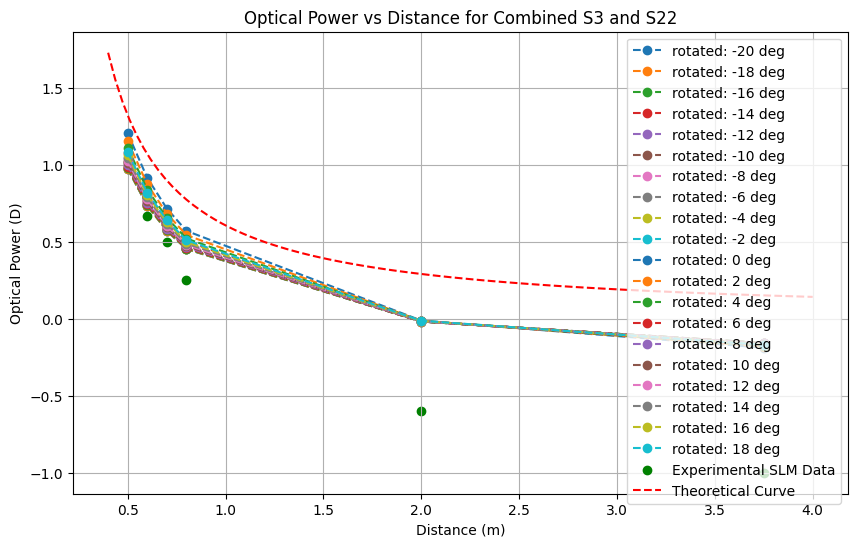

In [ ]:

# --- Configuration for CodeV session ---
WORKING_DIR = os.getcwd() + "\\"
LENS_FILE = WORKING_DIR + "system_with_camera" 
RESULTS_DIR = WORKING_DIR + "sensitivity_analysis\\"

# --- initialise variables ---
distances = [0.5, 0.6, 0.7, 0.8, 2, 3.75]
epsilon = 2

c0 = 1/0.00013312  # in mm

# surfaces for each epsilon
e1_surface = "S3"           # Lens 1 to Lens 2
e2_surface = "S7"           # Lens 2 to Lohmann lens
e3_surface = "S9"           # Lohmann to lens 3
e4_surface = "S12"          # Lens 3 to SLM
e5_surface = "S13"          # Lens 3 to SLM e5 must be  e5 = -e4
e6_surface = "S22"          # Lens 4 to lens 5
e7_surface = "S26"          # Lens 5 to lens 6
e8_surface = "S29"          # Lens 6 to camera's sensor

# --- 2. Initialize and Start CODE V Session ---
cv_session = None

try: 
    # create the COM object to interact with CODE V
    cv_session = win32com.client.Dispatch("CodeV.Application")
    print("Successfully created CODE V session object.")

    # set the working directory and start the background process
    cv_session.StartingDirectory = WORKING_DIR
    cv_session.StartCodeV()
    print(f"CODE V background process started. Version: {cv_session.CodeVVersion}")

    # open the specified lens file
    print(f"Opening lens: {LENS_FILE}...")
    output = cv_session.Command(f"RES {LENS_FILE}")
    print(f"Lens opened. CODE V response: {output}")

    # Ensure the results directory exists
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        print(f"Created results directory: {RESULTS_DIR}")

    # Initialize CodeVHelper
    cvHelper = cvh.CodeVHelper(cv_session)

    # get initial thickness of the surfaces
    s1_t = cvHelper.query_surf_thickness(e1_surface)
    s2_t = cvHelper.query_surf_thickness(e2_surface)
    s3_t = cvHelper.query_surf_thickness(e3_surface)
    s4_t = cvHelper.query_surf_thickness(e4_surface)
    s5_t = cvHelper.query_surf_thickness(e5_surface)
    s6_t = cvHelper.query_surf_thickness(e6_surface)
    s7_t = cvHelper.query_surf_thickness(e7_surface)
    s8_t = cvHelper.query_surf_thickness(e8_surface)

    surfaces_thickness = [s1_t, s6_t, s8_t]

    print(f"Initial thicknesses - {e1_surface}: {s1_t} mm, {e6_surface}: {s6_t} mm, {e8_surface}: {s8_t} mm")
    
    # reset thicknesses
    cvHelper.set_surf_thickness(e1_surface, s1_t)
    cvHelper.set_surf_thickness(e6_surface, s6_t)
    cvHelper.set_surf_thickness(e8_surface, s8_t)
    

    # --- Main Processing Loop ---

    #  experimental result
    p_SLM_m = [1.02, 0.67, 0.5, 0.25, -0.6, -1]

    # plot the theoretical curve
    d = np.linspace(0.4, 4, 100)  # distance in meters
    P = 9 / (16 * (d - 0.075))


    plt.figure(figsize=(10, 6))
    
    for i in np.arange(-20, 20, 2):
        rot = i
        powers = get_power_vs_distance_with_epsilon(cv_session, e1_surface, e6_surface, e8_surface, s1_t + -2, s6_t + -2, s8_t + 2, np.deg2rad(rot), distances)
        plt.plot(distances, powers, 'o--', label=f"rotated: {rot} deg")


    
    plt.scatter(distances, p_SLM_m, marker='o', color='g', label="Experimental SLM Data")
    plt.plot(d, P, 'r--', label="Theoretical Curve")
    plt.xlabel("Distance (m)")
    plt.ylabel("Optical Power (D)")
    plt.title("Optical Power vs Distance for Rotated Lohmann Lens")
    plt.grid()
    plt.legend()

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # --- Crlan Up and Close session ---
    if cv_session:
        cv_session.StopCodeV()
        print("\nCODE V session stopped.")
        cv_session = None


In [14]:
# --- Configuration for CodeV session ---
WORKING_DIR = os.getcwd() + "\\"
LENS_FILE = WORKING_DIR + "system_with_camera" 
RESULTS_DIR = WORKING_DIR + "sensitivity_analysis\\"

# --- initialise variables ---
distances = [0.5, 0.6, 0.7, 0.8, 2, 3.75]
epsilon = 2

c0 = 1/0.00013312  # in mm

# surfaces for each epsilon
e1_surface = "S3"           # Lens 1 to Lens 2
e2_surface = "S7"           # Lens 2 to Lohmann lens
e3_surface = "S9"           # Lohmann to lens 3
e4_surface = "S12"          # Lens 3 to SLM
e5_surface = "S13"          # Lens 3 to SLM e5 must be  e5 = -e4
e6_surface = "S22"          # Lens 4 to lens 5
e7_surface = "S26"          # Lens 5 to lens 6
e8_surface = "S29"          # Lens 6 to camera's sensor

# --- 2. Initialize and Start CODE V Session ---
cv_session = None

try: 
    # create the COM object to interact with CODE V
    cv_session = win32com.client.Dispatch("CodeV.Application")
    print("Successfully created CODE V session object.")

    # set the working directory and start the background process
    cv_session.StartingDirectory = WORKING_DIR
    cv_session.StartCodeV()
    print(f"CODE V background process started. Version: {cv_session.CodeVVersion}")

    # open the specified lens file
    print(f"Opening lens: {LENS_FILE}...")
    output = cv_session.Command(f"RES {LENS_FILE}")
    print(f"Lens opened. CODE V response: {output}")

    # Ensure the results directory exists
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        print(f"Created results directory: {RESULTS_DIR}")

    # Initialize CodeVHelper
    cvHelper = cvh.CodeVHelper(cv_session)

    rotate_lohmann_lens(cv_session, "S9", np.deg2rad(3), c0, True)
    
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # --- Crlan Up and Close session ---
    if cv_session:
        cv_session.StopCodeV()
        print("\nCODE V session stopped.")
        cv_session = None

Successfully created CODE V session object.
CODE V background process started. Version: 2022.03.SR1;Build (35834663)
Opening lens: c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera...
Lens opened. CODE V response: Warning: Index measured at 20.00 degrees with lens system at 22.00
               degrees for glass SILICA_SPECIAL
    File c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera.len has been restored
    Lens title: "AC254-100-A AC254-100-A POSITIVE VISIBLE ACHROMATS: Infinite 100"
    Error function:  0.1900246E+04
Command End:

Setting SCO S9 C7 0.00013259252359965946, output: Command End:

Setting SCO S9 C8 -1.975127003603406e-05, output: Command End:

Setting SCO S9 C9 2.193600768579027e-05, output: Command End:

Setting SCO S9 C10 0.0001325543578501462, output: Command End:


CODE V session stopped.


# Testing Rotation in the SLM

Successfully created CODE V session object.
CODE V background process started. Version: 2022.03.SR1;Build (35834663)
Opening lens: c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera_tilt_SLM...
Lens opened. CODE V response: Warning: Index measured at 20.00 degrees with lens system at 22.00
               degrees for glass SILICA_SPECIAL
    File c:\Users\crendon\Documents\Github\codev_python_com\system_with_camera_tilt_SLM.len has been restored
    Lens title: "AC254-100-A AC254-100-A POSITIVE VISIBLE ACHROMATS: Infinite 100"
    Error function:  0.1220783E+03
Command End:

Initial thicknesses - S3: 70.16935013025 mm, S22: 2.5 mm, S29: 2.5 mm
  Performing optimization: AUT; @x_coeff == (SCO S14 C2)/(SCO S14 C4) * (SCO S14 C7) - (SCO S13 C2); @y_coeff == (SCO S14 C7) / (SCO S14 C4) - (SCO S13 C3); @x_coeff = 0;             @y_coeff = 0; STP YES; ERR CDV; MNC 5; DRA S1..30  NO; EFP ALL Y; EFT TA; GLA SO..I  NFK5 NSK16 NLAF2 SF4; GO 
    AUT                             

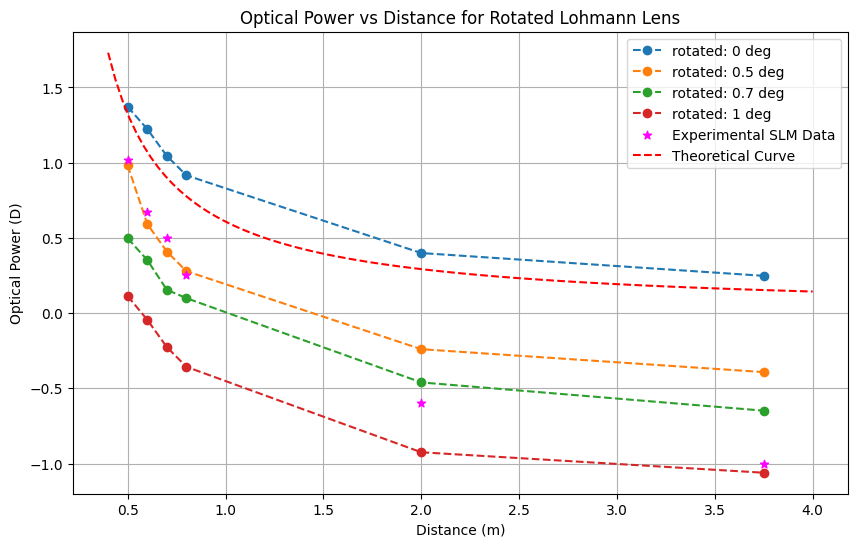

In [7]:

# --- Configuration for CodeV session ---
WORKING_DIR = os.getcwd() + "\\"
LENS_FILE = WORKING_DIR + "system_with_camera_tilt_SLM" 
RESULTS_DIR = WORKING_DIR + "sensitivity_analysis\\"

# --- initialise variables ---
distances = [0.5, 0.6, 0.7, 0.8, 2, 3.75]
epsilon = 2

c0 = 1/0.00013312  # in mm

# surfaces for each epsilon
e1_surface = "S3"           # Lens 1 to Lens 2
e2_surface = "S7"           # Lens 2 to Lohmann lens
e3_surface = "S9"           # Lohmann to lens 3
e4_surface = "S12"          # Lens 3 to SLM
e5_surface = "S13"          # Lens 3 to SLM e5 must be  e5 = -e4
e6_surface = "S22"          # Lens 4 to lens 5
e7_surface = "S26"          # Lens 5 to lens 6
e8_surface = "S29"          # Lens 6 to camera's sensor

# --- 2. Initialize and Start CODE V Session ---
cv_session = None

try: 
    # create the COM object to interact with CODE V
    cv_session = win32com.client.Dispatch("CodeV.Application")
    print("Successfully created CODE V session object.")

    # set the working directory and start the background process
    cv_session.StartingDirectory = WORKING_DIR
    cv_session.StartCodeV()
    print(f"CODE V background process started. Version: {cv_session.CodeVVersion}")

    # open the specified lens file
    print(f"Opening lens: {LENS_FILE}...")
    output = cv_session.Command(f"RES {LENS_FILE}")
    print(f"Lens opened. CODE V response: {output}")

    # Ensure the results directory exists
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        print(f"Created results directory: {RESULTS_DIR}")


    # # initialize the SLM tilt
    # command = f"SCO S14 C2 -0.03"
    # print(f"Applying command: {command}")
    # output = cv_session.Command(command)
    # print(f"Command output: {output}")

    # Initialize CodeVHelper
    cvHelper = cvh.CodeVHelper(cv_session, debug=False)

    # get initial thickness of the surfaces
    s1_t = cvHelper.query_surf_thickness(e1_surface)
    s2_t = cvHelper.query_surf_thickness(e2_surface)
    s3_t = cvHelper.query_surf_thickness(e3_surface)
    s4_t = cvHelper.query_surf_thickness(e4_surface)
    s5_t = cvHelper.query_surf_thickness(e5_surface)
    s6_t = cvHelper.query_surf_thickness(e6_surface)
    s7_t = cvHelper.query_surf_thickness(e7_surface)
    s8_t = cvHelper.query_surf_thickness(e8_surface)

    surfaces_thickness = [s1_t, s6_t, s8_t]

    print(f"Initial thicknesses - {e1_surface}: {s1_t} mm, {e6_surface}: {s6_t} mm, {e8_surface}: {s8_t} mm")
    
    # reset thicknesses
    cvHelper.set_surf_thickness(e1_surface, s1_t)
    cvHelper.set_surf_thickness(e6_surface, s6_t)
    cvHelper.set_surf_thickness(e8_surface, s8_t)
    

    # --- Main Processing Loop ---

    #  experimental result
    p_SLM_m = [1.02, 0.67, 0.5, 0.25, -0.6, -1]

    # plot the theoretical curve
    d = np.linspace(0.4, 4, 100)  # distance in meters
    P = 9 / (16 * (d - 0.075))


    plt.figure(figsize=(10, 6))
    axis = 'x'
    #for i in np.arange(-0.5, 0.5, 0.1):
    for i in [0, 0.5, 0.7, 1]:
        rot = i
        powers = get_power_vs_distance_with_SLM_tilt(cv_session, e1_surface, e6_surface, e8_surface, s1_t + 0, s6_t + 0, s8_t + 0, np.deg2rad(-rot), np.deg2rad(rot), distances, axis=axis)
        plt.plot(distances, powers, 'o--', label=f"rotated: {rot} deg")


    
    plt.scatter(distances, p_SLM_m, marker='*', color='magenta', zorder = 1000, label="Experimental SLM Data")
    plt.plot(d, P, 'r--', label="Theoretical Curve")
    plt.xlabel("Distance (m)")
    plt.ylabel("Optical Power (D)")
    plt.title("Optical Power vs Distance for Rotated Lohmann Lens")
    plt.grid()
    plt.legend()

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # --- Crlan Up and Close session ---
    if cv_session:
        cv_session.StopCodeV()
        print("\nCODE V session stopped.")
        cv_session = None
